In [1]:
!pip install torchbnn

In [2]:
import numpy as np
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import torchbnn as bnn

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Constants
batch_size = 128
num_classes = 10
input_dim = 784

# Hyperparameters
lr = 1e-4
log_sigma1 = -1
hidden_dim = 1200

In [5]:
# iris = datasets.load_iris()
training_data = datasets.MNIST(root='data', train=True, download=True, transform=ToTensor())
training_set, validation_set = torch.utils.data.random_split(training_data, [50000, 10000])
test_data = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())

training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [6]:
num_trainbatches = int(len(training_set) / batch_size) + 1
train_denom = 2 ** num_trainbatches  - 1

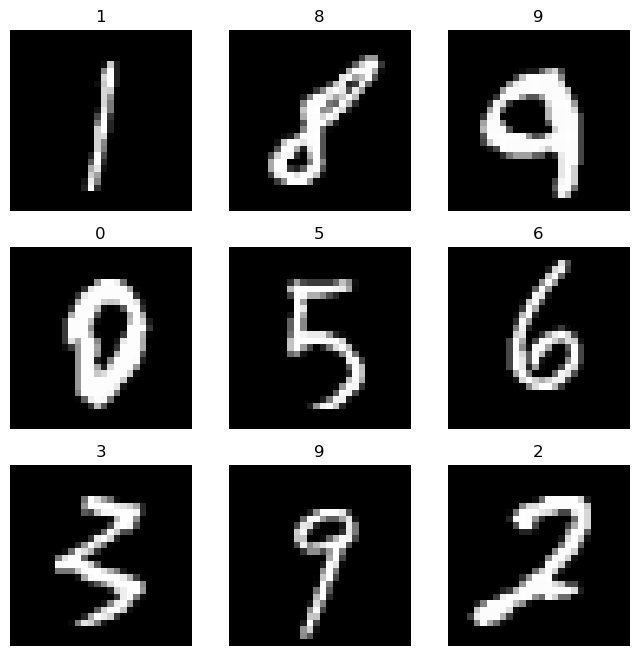

In [7]:
# Visualize the data
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# No need to normalize. The data values are already between 0 and 1

In [8]:
# print(img.shape)
print(len(training_set),len(validation_set))

50000 10000


In [9]:
sigma1 = 10 ** log_sigma1

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=sigma1, in_features=input_dim, out_features=hidden_dim, bias=False),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=sigma1, in_features=hidden_dim, out_features=hidden_dim, bias=False),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=sigma1, in_features=hidden_dim, out_features=num_classes, bias=False),
)

In [10]:
ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
# kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        inputs = inputs.view(-1, 784)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        ################## WE CAN AVERAGE ACROSS MULTIPLE W SAMPLES HERE BEFORE DOING loss.backward() #########################
        outputs = model(inputs)

        # Compute the loss and its gradients
        ce = ce_loss(outputs, labels)
        kl = kl_loss(model)
        kl_weight = 2 ** (num_trainbatches-i) / train_denom
        loss = ce + kl_weight * kl
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [12]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/MNIST_trainer_{}'.format(timestamp))
epoch_number = 0

val_loss = []
val_accuracy = []

test_loss = []
test_accuracy = []

EPOCHS = 300

best_vloss = 1_000_000.
num_vbatches = int(len(validation_set) / batch_size) + 1
vdenom = 2 ** num_vbatches - 1

num_tbatches = int(len(test_data) / batch_size) + 1
tdenom = 2 ** num_tbatches - 1

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    correct = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.view(-1, 784)
        voutputs = model(vinputs)
        _, predicted = torch.max(voutputs, 1)
        correct += torch.sum(vlabels == predicted)
        vce = ce_loss(voutputs, vlabels)
        vkl = kl_loss(model)
        kl_weight = 2**(num_vbatches-i) / vdenom
        vloss = vce + kl_weight * vkl
        running_vloss += vloss.item()

    avg_vloss = running_vloss / (i + 1)
    val_loss.append(avg_vloss)
    val_accuracy.append(100 * float(correct)/ len(validation_set))

    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('valid accuracy {}'.format(val_accuracy[-1]))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = './models/gaussian-prior/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    
    running_tloss = 0.0
    correct = 0

    for i, tdata in enumerate(test_loader):
        tinputs, tlabels = tdata
        tinputs = tinputs.view(-1, 784)
        toutputs = model(tinputs)
        _, predicted = torch.max(toutputs, 1)
        correct += torch.sum(tlabels == predicted)
        tloss = ce_loss(voutputs, vlabels)
        running_tloss += tloss.item()

    avg_tloss = running_tloss / (i + 1)

    test_loss.append(avg_tloss)
    test_accuracy.append(100 * float(correct)/ len(test_data))
    print('test accuracy {}'.format(test_accuracy[-1]))

    epoch_number += 1

EPOCH 1:
  batch 100 loss: 8.467106261253356
  batch 200 loss: 7.729285206794739
  batch 300 loss: 6.474286193847656
LOSS train 6.474286193847656 valid 5.787351052972335
valid accuracy 10.5
test accuracy 10.46
EPOCH 2:
  batch 100 loss: 5.5274017667770385
  batch 200 loss: 5.196687185764313
  batch 300 loss: 4.735077016353607
LOSS train 4.735077016353607 valid 4.328024903430214
valid accuracy 10.03
test accuracy 9.81
EPOCH 3:
  batch 100 loss: 4.325763711929321
  batch 200 loss: 4.110598168373108
  batch 300 loss: 3.863715200424194
LOSS train 3.863715200424194 valid 3.6318890535378756
valid accuracy 10.55
test accuracy 10.05
EPOCH 4:
  batch 100 loss: 3.5319473552703857
  batch 200 loss: 3.4836619186401365
  batch 300 loss: 3.363242678642273
LOSS train 3.363242678642273 valid 3.1684568230109877
valid accuracy 11.39
test accuracy 10.15
EPOCH 5:
  batch 100 loss: 3.203986644744873
  batch 200 loss: 3.129839401245117
  batch 300 loss: 3.0767604875564576
LOSS train 3.0767604875564576 valid

  batch 100 loss: 0.3405824040621519
  batch 200 loss: 0.32515482932329176
  batch 300 loss: 0.3469628955423832
LOSS train 0.3469628955423832 valid 0.34347862816309627
valid accuracy 89.61
test accuracy 90.05
EPOCH 40:
  batch 100 loss: 0.31439870908856393
  batch 200 loss: 0.31381992556154725
  batch 300 loss: 0.3244291864335537
LOSS train 0.3244291864335537 valid 0.32172788981395434
valid accuracy 90.27
test accuracy 90.59
EPOCH 41:
  batch 100 loss: 0.31904579684138296
  batch 200 loss: 0.3089143507182598
  batch 300 loss: 0.3157603707164526
LOSS train 0.3157603707164526 valid 0.3115287959764275
valid accuracy 90.59
test accuracy 90.83
EPOCH 42:
  batch 100 loss: 0.2899281112104654
  batch 200 loss: 0.3026174530386925
  batch 300 loss: 0.30889287203550336
LOSS train 0.30889287203550336 valid 0.29761605851257905
valid accuracy 91.21
test accuracy 91.02
EPOCH 43:
  batch 100 loss: 0.3015387736260891
  batch 200 loss: 0.2971583868563175
  batch 300 loss: 0.2884974719583988
LOSS train 0

  batch 300 loss: 0.13597683217376472
LOSS train 0.13597683217376472 valid 0.16532308657806885
valid accuracy 95.25
test accuracy 95.44
EPOCH 77:
  batch 100 loss: 0.1261585591547191
  batch 200 loss: 0.12387018680572509
  batch 300 loss: 0.13945111490786075
LOSS train 0.13945111490786075 valid 0.15942684136614016
valid accuracy 95.26
test accuracy 95.48
EPOCH 78:
  batch 100 loss: 0.1327340155467391
  batch 200 loss: 0.128977462798357
  batch 300 loss: 0.12854004051536322
LOSS train 0.12854004051536322 valid 0.1633692593608476
valid accuracy 95.23
test accuracy 95.51
EPOCH 79:
  batch 100 loss: 0.12759467300027608
  batch 200 loss: 0.11765244707465172
  batch 300 loss: 0.12784759737551213
LOSS train 0.12784759737551213 valid 0.16759626065156882
valid accuracy 95.27
test accuracy 95.68
EPOCH 80:
  batch 100 loss: 0.12276397300884127
  batch 200 loss: 0.12479426080361009
  batch 300 loss: 0.12020181640982627
LOSS train 0.12020181640982627 valid 0.16250184607468074
valid accuracy 95.38
t

LOSS train 0.07042460255324841 valid 0.12676653382663108
valid accuracy 96.49
test accuracy 96.65
EPOCH 114:
  batch 100 loss: 0.07287027838174254
  batch 200 loss: 0.0692017442267388
  batch 300 loss: 0.07165088157635183
LOSS train 0.07165088157635183 valid 0.12910244830212073
valid accuracy 96.61
test accuracy 96.91
EPOCH 115:
  batch 100 loss: 0.07003947709687054
  batch 200 loss: 0.0721826409175992
  batch 300 loss: 0.06971828592941165
LOSS train 0.06971828592941165 valid 0.13109097528401054
valid accuracy 96.5
test accuracy 96.5
EPOCH 116:
  batch 100 loss: 0.07010542198084295
  batch 200 loss: 0.06810183549299836
  batch 300 loss: 0.07507767162285744
LOSS train 0.07507767162285744 valid 0.13080612600698502
valid accuracy 96.54
test accuracy 96.86
EPOCH 117:
  batch 100 loss: 0.07851764380931854
  batch 200 loss: 0.055548345828428866
  batch 300 loss: 0.06312727817334235
LOSS train 0.06312727817334235 valid 0.13040458021944837
valid accuracy 96.62
test accuracy 96.94
EPOCH 118:
  

  batch 300 loss: 0.03862566792406142
LOSS train 0.03862566792406142 valid 0.11879793745837663
valid accuracy 96.97
test accuracy 97.35
EPOCH 151:
  batch 100 loss: 0.04889386388240382
  batch 200 loss: 0.0392458225809969
  batch 300 loss: 0.046558720956090836
LOSS train 0.046558720956090836 valid 0.122127410109874
valid accuracy 96.95
test accuracy 97.36
EPOCH 152:
  batch 100 loss: 0.04344709153054282
  batch 200 loss: 0.04356561078922823
  batch 300 loss: 0.04755607866449282
LOSS train 0.04755607866449282 valid 0.11424533219394993
valid accuracy 97.09
test accuracy 97.42
EPOCH 153:
  batch 100 loss: 0.03859241610392928
  batch 200 loss: 0.04635518222581595
  batch 300 loss: 0.04024861407931894
LOSS train 0.04024861407931894 valid 0.11777339664087454
valid accuracy 97.18
test accuracy 97.19
EPOCH 154:
  batch 100 loss: 0.044843039107508954
  batch 200 loss: 0.04282302498817444
  batch 300 loss: 0.040593755857553336
LOSS train 0.040593755857553336 valid 0.12138438420930193
valid accur

  batch 100 loss: 0.02789062978408765
  batch 200 loss: 0.030922537503938655
  batch 300 loss: 0.02383736637595575
LOSS train 0.02383736637595575 valid 0.11890871333815983
valid accuracy 97.62
test accuracy 97.67
EPOCH 188:
  batch 100 loss: 0.027032606811844745
  batch 200 loss: 0.024224137876590248
  batch 300 loss: 0.034947552585508676
LOSS train 0.034947552585508676 valid 0.12030868937962842
valid accuracy 97.33
test accuracy 97.73
EPOCH 189:
  batch 100 loss: 0.024361093290499413
  batch 200 loss: 0.02625310037401505
  batch 300 loss: 0.026626540545839815
LOSS train 0.026626540545839815 valid 0.12839458719532512
valid accuracy 97.32
test accuracy 97.75
EPOCH 190:
  batch 100 loss: 0.026768781228456648
  batch 200 loss: 0.02178896101715509
  batch 300 loss: 0.02563429149799049
LOSS train 0.02563429149799049 valid 0.1200233684709779
valid accuracy 97.35
test accuracy 97.72
EPOCH 191:
  batch 100 loss: 0.02565916083753109
  batch 200 loss: 0.023346080401097424
  batch 300 loss: 0.020

LOSS train 0.016741883042377594 valid 0.1349902709741941
valid accuracy 97.61
test accuracy 97.87
EPOCH 224:
  batch 100 loss: 0.021434359091435908
  batch 200 loss: 0.01644268317257229
  batch 300 loss: 0.014239302127280098
LOSS train 0.014239302127280098 valid 0.1418218489884048
valid accuracy 97.58
test accuracy 97.82
EPOCH 225:
  batch 100 loss: 0.016266395353159168
  batch 200 loss: 0.015108378098229878
  batch 300 loss: 0.015512403858083416
LOSS train 0.015512403858083416 valid 0.13709681013619668
valid accuracy 97.52
test accuracy 97.92
EPOCH 226:
  batch 100 loss: 0.015886069845801102
  batch 200 loss: 0.015318604106287239
  batch 300 loss: 0.015067060420624329
LOSS train 0.015067060420624329 valid 0.13087207472830115
valid accuracy 97.59
test accuracy 97.93
EPOCH 227:
  batch 100 loss: 0.016642736066423823
  batch 200 loss: 0.014646279224834871
  batch 300 loss: 0.011670379953357042
LOSS train 0.011670379953357042 valid 0.13042485817903623
valid accuracy 97.5
test accuracy 97.

test accuracy 97.86
EPOCH 260:
  batch 100 loss: 0.013380739711901696
  batch 200 loss: 0.008070026140521804
  batch 300 loss: 0.011907575091227045
LOSS train 0.011907575091227045 valid 0.15869677343752173
valid accuracy 97.7
test accuracy 97.93
EPOCH 261:
  batch 100 loss: 0.01323948924909928
  batch 200 loss: 0.01097346875558287
  batch 300 loss: 0.010190687365629857
LOSS train 0.010190687365629857 valid 0.14106485450086242
valid accuracy 97.67
test accuracy 97.98
EPOCH 262:
  batch 100 loss: 0.012263726055186908
  batch 200 loss: 0.009554695661136066
  batch 300 loss: 0.009093683268570203
LOSS train 0.009093683268570203 valid 0.14619689835091798
valid accuracy 97.61
test accuracy 97.99
EPOCH 263:
  batch 100 loss: 0.013273737924391753
  batch 200 loss: 0.009368504121539445
  batch 300 loss: 0.00749862463100726
LOSS train 0.00749862463100726 valid 0.14860389638108498
valid accuracy 97.86
test accuracy 97.82
EPOCH 264:
  batch 100 loss: 0.012661930501867574
  batch 200 loss: 0.0111012

  batch 200 loss: 0.005632230749506561
  batch 300 loss: 0.006867610244893285
LOSS train 0.006867610244893285 valid 0.15670995286199044
valid accuracy 97.6
test accuracy 97.97
EPOCH 297:
  batch 100 loss: 0.00863911656711025
  batch 200 loss: 0.006031689003548308
  batch 300 loss: 0.007441860556816664
LOSS train 0.007441860556816664 valid 0.1570693970529128
valid accuracy 97.96
test accuracy 98.03
EPOCH 298:
  batch 100 loss: 0.012071734133182872
  batch 200 loss: 0.006522710011795425
  batch 300 loss: 0.006069924478342727
LOSS train 0.006069924478342727 valid 0.14720213603180163
valid accuracy 97.83
test accuracy 97.92
EPOCH 299:
  batch 100 loss: 0.011837149854227392
  batch 200 loss: 0.0067846789538543815
  batch 300 loss: 0.006285742032448524
LOSS train 0.006285742032448524 valid 0.14483487131433775
valid accuracy 97.92
test accuracy 97.92
EPOCH 300:
  batch 100 loss: 0.007569253519914127
  batch 200 loss: 0.004809390626555796
  batch 300 loss: 0.005687654467583343
LOSS train 0.005

In [14]:
data = {}
data['test-loss'] = test_loss
data['test-accuracy'] = test_accuracy
data['validation-loss'] = val_loss
data['validation-accuracy'] = val_accuracy

import pickle

with open('./models/gaussian-prior/test-loss', 'wb') as f:
    pickle.dump(data, f)

# Test 

In [15]:
model.train(False)

running_tloss = 0.0
correct = 0

num_tbatches = int(len(test_data) / batch_size) + 1
tdenom = 2 ** num_tbatches - 1

for i, tdata in enumerate(test_loader):
    tinputs, tlabels = tdata
    tinputs = tinputs.view(-1, 784)
    toutputs = model(tinputs)
    _, predicted = torch.max(toutputs, 1)
    correct += torch.sum(tlabels == predicted)
    tce = ce_loss(toutputs, tlabels)
    tkl = kl_loss(model)
    kl_weight = 2**(num_tbatches - i) / tdenom
    tloss = tce + kl_weight * tkl
    running_tloss += tloss.item()

avg_tloss = running_tloss / (i + 1)
print('LOSS test {}'.format(avg_tloss))
print("Number of correct predictions {}".format(correct))

print("Accuracy: {:.2f}".format(100 * float(correct)/ len(test_data)))


LOSS test 0.14686702648890415
Number of correct predictions 9789
Accuracy: 97.89


In [16]:
model_path = './models/gaussian-prior/model_{}_{}'.format(timestamp, epoch_number)
torch.save(model.state_dict(), model_path)

In [ ]:
# for step in range(3000):
#     pre = model(x)
#     ce = ce_loss(pre, y)
#     kl = kl_loss(model)
#     cost = ce + kl_weight*kl
    
#     optimizer.zero_grad()
#     cost.backward()
#     optimizer.step()
    
# _, predicted = torch.max(pre.data, 1)
# total = y.size(0)
# correct = (predicted == y).sum()
# print('- Accuracy: %f %%' % (100 * float(correct) / total))
# print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

# Test Model

In [ ]:
# def draw_plot(predicted) :
#     fig = plt.figure(figsize = (16, 5))

#     ax1 = fig.add_subplot(1, 2, 1)
#     ax2 = fig.add_subplot(1, 2, 2)

#     z1_plot = ax1.scatter(X[:, 0], X[:, 1], c = Y)
#     z2_plot = ax2.scatter(X[:, 0], X[:, 1], c = predicted)

#     plt.colorbar(z1_plot,ax=ax1)
#     plt.colorbar(z2_plot,ax=ax2)

#     ax1.set_title("REAL")
#     ax2.set_title("PREDICT")

#     plt.show()

In [ ]:
# pre = model(x)
# _, predicted = torch.max(pre.data, 1)
# draw_plot(predicted)

In [ ]:
# Bayesian Neural Network will return different outputs even if inputs are same.
# In other words, different plots will be shown every time forward method is called.
# pre = model(x)
# _, predicted = torch.max(pre.data, 1)
# draw_plot(predicted)